# CPS600 - Python Programming for Finance 
###  
<img src="https://www.syracuse.edu/wp-content/themes/g6-carbon/img/syracuse-university-seal.svg?ver=6.3.9" style="width: 150px;"/>

## Term Project

### Group members:
Name: `Wei Mu` SUID: `956340308`

Name: `Hao Tang` SUID: `0000`

Name: `Shichen Peng` SUID: `00000`



### Simulation

**Random Variables**

In the Black-Scholes-Merton setup for option pricing, the level of a stock index $S_T$ at a future date $T$ given a level $S_0$ as of today is given according to the following equation:

$$ S_T = S_0\exp((r-\frac{1}{2}\sigma^2)T + \sigma\sqrt{T}z)$$

The variables and parameters are defined as following:

* $S_T$ is the index level at time $T$.
* $r$ is the constant riskless short rate.
* $\sigma$ is the constant volatility (= standard deviation of returns) of $S$.
* $z$ is a *standard normally distributed* random variable.

Setting up simulation and visualize:

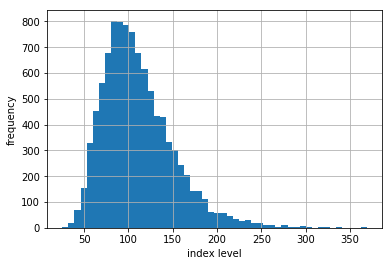

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline


S0 = 100                                                  # Initial value
r = 0.05                                                  # Constant Short Rate
sigma = 0.25                                              # Volatility
T = 2.0                                                   # in years
I = 10000                                                 # number of random draws
z = npr.standard_normal(I)
ST1 = S0*np.exp((r-.5*sigma**2)*T + sigma*np.sqrt(T)*z)
plt.hist(ST1, bins=50)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.grid(True)

Because it looks like log-normal distributed, we can also sample from the log-normal:

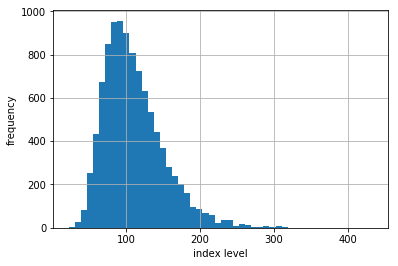

In [2]:
ST2 = S0 * npr.lognormal((r-.5*sigma**2)*T, sigma * np.sqrt(T), size=I)
plt.hist(ST2, bins=50)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.grid(True)

Comparing statistics of the the distribtions:

In [3]:
import scipy.stats as scs


def print_statistics(a1,a2):
    sta1=scs.describe(a1)
    sta2=scs.describe(a2)
    print("%14s %14s %14s" % ('statistic','data set 1', 'data set 2') )
    print(45*"")
    print("%14s %14.3f %14.3f" % ('size', sta1[0], sta2[0]))
    print("%14s %14.3f %14.3f" % ('min', sta1[1][0], sta2[1][0]))
    print("%14s %14.3f %14.3f" % ('max', sta1[1][1], sta2[1][1]))
    print("%14s %14.3f %14.3f" % ('mean', sta1[2], sta2[2]))
    print("%14s %14.3f %14.3f" % ('std', np.sqrt(sta1[3]), np.sqrt(sta2[3])))
    print("%14s %14.3f %14.3f" % ('skew', sta1[4], sta2[4]))
    print("%14s %14.3f %14.3f" % ('kurtosis', sta1[5], sta2[5]))

    
print_statistics(ST1,ST2)

     statistic     data set 1     data set 2

          size      10000.000      10000.000
           min         25.407         22.537
           max        368.682        434.207
          mean        110.921        110.922
           std         40.470         40.704
          skew          1.179          1.139
      kurtosis          2.465          2.233


The statistics of both simulation results are quite similar. The differences are
mainly due to the *sampling error* in simulation. Error can also be introduced
when discretely simulating continuous stochastic processes — namely the *discretization
error*, which plays no role here due to the static nature of the simulation approach.

**Stochastic Processes**

Roughly speaking, a *stochastic process* is a sequence of random variables. In that sense,
we should expect something similar to a sequence of repeated simulations of a random
variable when simulating a process. This is mainly true, apart from the fact that the draws
are in general not independent but rather depend on the result(s) of the previous draw(s).

In finance, stochastic processes generally exhibit the *Markov property*:
>that	tomorrow’s	value	of	the	process	only	depends	on	today’s	state	of
the	process,	and	not	any	other	more	“historic”	state	or	even	the	whole	path	history.	The
process	then	is	also	called	memoryless.

**Geometric Brownian Motion**

Consider the BSM model in its differential form:

$$ S_t = S_{t-\Delta t} \exp((r-\frac{1}{2}\sigma^2)\Delta t + \sigma\sqrt{\Delta t}z_t) $$

We translate into Python:

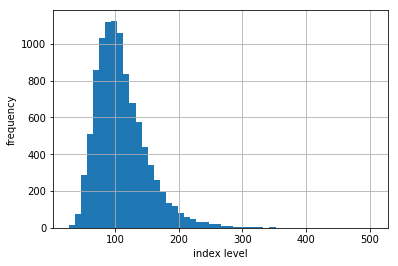

In [4]:
I = 10000
M = 50
dt = T / M
S = np.zeros((M+1,I))
S[0] = S0
for t in range(1,M+1):
    S[t] = S[t-1]*np.exp((r - .5*sigma**2)*dt
                         + sigma * np.sqrt(dt) * npr.standard_normal(I))
plt.hist(S[-1], bins=50)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.grid(True)

The data have a lognormal distribution. The summary statistics:

In [5]:
print_statistics(S[-1],ST2)

     statistic     data set 1     data set 2

          size      10000.000      10000.000
           min         26.877         22.537
           max        505.283        434.207
          mean        110.298        110.922
           std         40.716         40.704
          skew          1.330          1.139
      kurtosis          3.593          2.233


Now we visualize the first 10 *simulated paths*

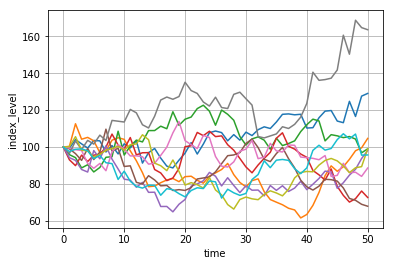

In [6]:
plt.plot(S[:,:10],lw=1.5)
plt.xlabel('time')
plt.ylabel('index_level')
plt.grid(True)

**Square-root Diffusion**

Another important class of financial processes is *mean-reverting processes*, which are
used to model short rates or volatility processes, for example. A popular and widely used
model is the *square-root diffusion*, as proposed by Cox, Ingersoll, and Ross (1985).

The stochastic differential equation for square-root diffusion:

$$ dx_t = \kappa (\theta - x_t)dt + \sigma \sqrt{x_t}dZ_t$$

The values of these terms are as follows

* $x_t$ is the process level at date t
* $\kappa$ is the mean-reversion factor
* $\theta$ is the long-term mean of the process
* $\sigma$ is the constant volatility parameter
* $Z$, as before, is the *standard Brownian motion* variable

Applying Euler's method to the above differential equation yields:

$$\tilde{x_t} = \tilde{x_s} + \kappa(\theta - \tilde{x_s})\Delta t + \sigma \sqrt{\tilde{x_s}^+}\sqrt{\Delta t} z_t $$

$$ x_t = \tilde{x_t}^+ $$

$x^+$ means the *maximum of $x$ and $0$*.

Now we will initialize the parameters and start the *discretization*:

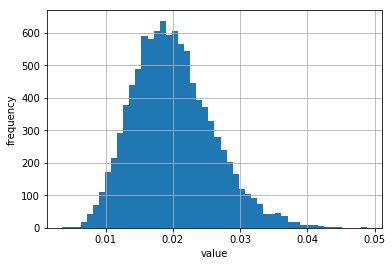

In [7]:
x0, kappa, theta, sigma = 0.05, 3.0, 0.02, 0.1
T = 2.0
M = 50
I, dt = 10000, T / M


def srd_euler():
    xh = np.zeros((M + 1, I))
    x1 = np.zeros_like(xh)
    xh[0] = x0
    x1[0] = x0
    for t in range(1, M + 1):
        xh[t] = (xh[t - 1]
                    + kappa * (theta - np.maximum(xh[t - 1], 0)) * dt
                    + sigma * np.sqrt(np.maximum(xh[t - 1], 0)) * np.sqrt(dt)
                    * npr.standard_normal(I))
    return np.maximum(xh, 0)


x1 = srd_euler()
plt.hist(x1[-1],bins=50)
plt.xlabel('value')
plt.ylabel('frequency')
plt.grid(True)

The simulation results in a histogram are as above. The first 10 simulated paths:

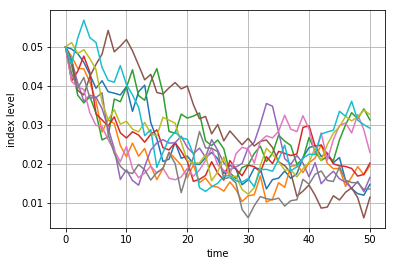

In [8]:
plt.plot(x1[:,:10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)

We can get results that are mathematically more precise using another method. The following equation presents the exact discretization scheme for the square-root diffusion based on the noncentral chi-square distribution $\displaystyle {\chi'^{2}_d}$ with $\displaystyle df=\frac{4 \theta \kappa}{\sigma^2}$ degrees of freedom and noncentrality parameter $ \displaystyle nc=\frac{4 \kappa e^{-\kappa \Delta t}}{\sigma^2(1 - e^{-\kappa \Delta t})}x_s$

$$ x_t = \frac{\sigma^2(1 - e^{-\kappa \Delta t})}{4 \kappa} \chi'^2_d\Big(\frac{4 \kappa e^{-\kappa \Delta t}}{\sigma^2(1 - e^{-\kappa \Delta t})}x_s\Big) $$

And here is the Python implementation:

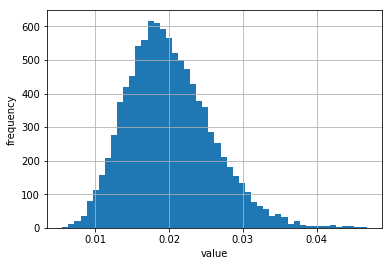

In [9]:
def srd_exact():
    x2 = np.zeros((M + 1, I))
    x2[0] = x0
    for t in range(1, M + 1):
        df = 4 * theta * kappa / sigma ** 2
        c = (sigma ** 2 * (1 - np.exp(-kappa * dt))) / (4 * kappa)
        nc = np.exp(-kappa * dt) / c * x2[t - 1]
        x2[t] = c * npr.noncentral_chisquare(df, nc, size=I)
    return x2


x2 = srd_exact()
plt.hist(x2[-1],bins=50)
plt.xlabel('value')
plt.ylabel('frequency')
plt.grid(True)

The following figure presents the first 10 simulated paths

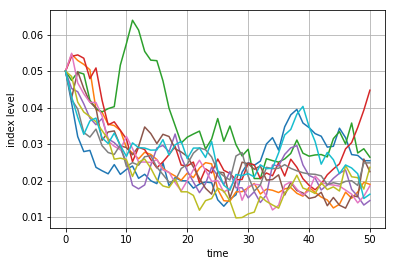

In [10]:
plt.plot(x2[:,:10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)

Comparing the main statistics from the different approaches reveals that the biased Euler
scheme indeed performs quite well when it comes to the desired statistical properties:

In [11]:
print_statistics(x1[-1], x2[-1])

     statistic     data set 1     data set 2

          size      10000.000      10000.000
           min          0.004          0.006
           max          0.049          0.047
          mean          0.020          0.020
           std          0.006          0.006
          skew          0.535          0.572
      kurtosis          0.335          0.490


However, a major difference can be observed in terms of execution speed, since sampling from the noncentral chi-square distribution is more computationally demanding than from the standard normal distribution.

In [12]:
I = 250000
%time x1 = srd_euler()

CPU times: user 576 ms, sys: 95.7 ms, total: 672 ms
Wall time: 655 ms


In [13]:
%time x2 = srd_exact()

CPU times: user 1.32 s, sys: 27.7 ms, total: 1.35 s
Wall time: 1.35 s


The exact scheme takes roughly twice as much time for virtually the same results as with
the Euler scheme:

In [14]:
print_statistics(x1[-1], x2[-1])

     statistic     data set 1     data set 2

          size     250000.000     250000.000
           min          0.002          0.003
           max          0.059          0.059
          mean          0.020          0.020
           std          0.006          0.006
          skew          0.554          0.571
      kurtosis          0.469          0.473


**Stochastic volatility**

One of the major simplifying assumptions of the Black-Scholes-Merton model is the *constant* volatility. However, volatility in general is neither constant nor deterministic; it is *stochastic*. Therefore, a major advancement with regard to financial modeling was achieved in the early 1990s with the introduction of so-called *stochastic volatility models*.

One of the most popular models that fall into that category is that of Heston (1993), which
is presented as the following equation:

$$dS_t = r{S_t}dt + \sqrt{v_t}{S_t}d{Z_t^1}$$

$$dv_t = \kappa_v (\theta_v - v_t)dt + \sigma_v\sqrt{v_t}d{Z_t^2}$$

$$d{Z_t^1}d{Z_t^2} = \rho$$

The parameter represents the instantaneous correlation between the two standard Brownian motions $Z_t^1$ and $Z_t^2$. This allows us to account for a stylized fact called *the leverage effect*, which in essence states that volatility goes up in times of stress (declining markets) and goes down in times of a bull market (rising markets).

Python implementation:

[[1.  0. ]
 [0.6 0.8]]


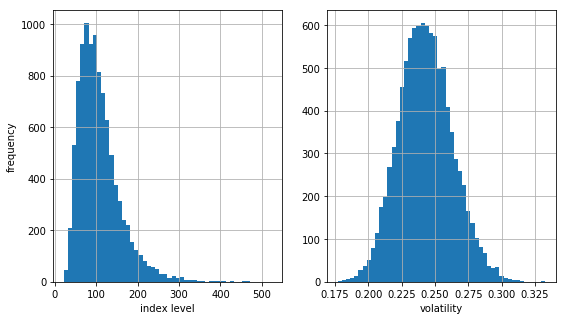

In [15]:
S0 = 100.
r = 0.05
v0 = 0.1
kappa = 3.0
theta = 0.25
sigma = 0.1
rho = 0.6
T = 1.0

# Determine the Cholesky decomposition of the correlation matrix
corr_mat = np.zeros((2, 2))
corr_mat[0, :] = [1.0, rho]
corr_mat[1, :] = [rho, 1.0]
cho_mat = np.linalg.cholesky(corr_mat)
print(cho_mat)

# Generate the whole set of random numbers for both processes
M = 50
I = 10000
ran_num = npr.standard_normal((2, M + 1, I))

# Euler scheme, taking into account the correlation parameter
dt = T / M
v = np.zeros_like(ran_num[0])
vh = np.zeros_like(v)
v[0] = v0
vh[0] = v0
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    vh[t] = (vh[t - 1] + kappa * (theta - np.maximum(vh[t - 1], 0)) * dt
        + sigma * np.sqrt(np.maximum(vh[t - 1], 0)) * np.sqrt(dt)
        * ran[1])
v = np.maximum(vh, 0)

S = np.zeros_like(ran_num[0])
S[0] = S0
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt +
        np.sqrt(v[t]) * ran[0] * np.sqrt(dt))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
ax1.hist(S[-1], bins=50)
ax1.set_xlabel('index level')
ax1.set_ylabel('frequency')
ax1.grid(True)
ax2.hist(v[-1], bins=50)
ax2.set_xlabel('volatility')
ax2.grid(True)

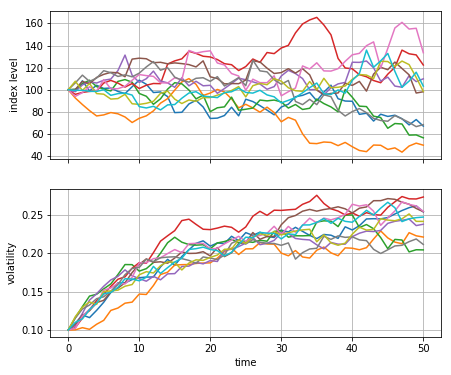

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 6))
ax1.plot(S[:, :10], lw=1.5)
ax1.set_ylabel('index level')
ax1.grid(True)
ax2.plot(v[:, :10], lw=1.5)
ax2.set_xlabel('time')
ax2.set_ylabel('volatility')
ax2.grid(True)

The statistics for the last point in time for both data sets shows a pretty high maximum value for the index level process.In fact, this is much higher than a geometric Brownian motion with constant volatility could ever climb.

In [17]:
print_statistics(S[-1], v[-1])

     statistic     data set 1     data set 2

          size      10000.000      10000.000
           min         21.287          0.177
           max        522.698          0.333
          mean        107.650          0.243
           std         51.480          0.020
          skew          1.631          0.178
      kurtosis          4.934          0.000


**Jump Diffusion**

Stochastic volatility and the leverage effect are stylized (empirical) facts found in a number of markets. Another important stylized empirical fact is the existence of jumps in asset prices and, for example, volatility. In 1976, Merton published his jump diffusion model, enhancing the Black-Scholes-Merton setup by a model component generating jumps with log-normal distribution. The risk-neutral SDE is presented in the following equation:

$$d{S_t} = (r-r_J){S_t}dt + {S_t}d{Z_t} + {J_t}{S_t}d{N_t}$$

The values of these terms are as follows:

- $S_t$ is the index level at date t
- $r$ is the constant riskless short rate
- $r_J \equiv \lambda (e^{\mu_J + \delta^2/2}-1)$ is the drift correction for jump to maintain risk neutrality
- $\sigma$ is the constant volatility of S
- $Z_t$ is the Standard Brownian motion
- $J$ is jump at date t with distribution 
> $log(1+N) \approx \mathbf{N}(log(1+\mu_J)-\delta^2/2, \delta^2)$ with $\mathbf{N}$ as the cumulative distribution function of a standard normal random variable.
- $N_t$ is the poisson process variable with intensity

The following equation presents an Euler discretization for the jump diffusion where the $Z_t^n$ are standard normally distributed and the $y_t$ are Poisson distributed with intensity.

$$\large S_t = S_{t-\Delta t} \Big(e^{(r-r_J-\sigma^2/2)\Delta t+\sigma \sqrt{\Delta t} z_t^1} + (e^{\mu_J+\delta z_t^2} - 1)y_t \Big)$$

Python implementation:

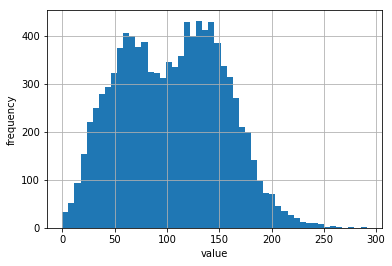

In [18]:
S0 = 100.
r = 0.05
sigma = 0.2
lamb = 0.75
mu = -0.6
delta = 0.25
T = 1.0

M = 50
I = 10000
dt = T / M
rj = lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
S = np.zeros((M + 1, I))
S[0] = S0
sn1 = npr.standard_normal((M + 1, I))
sn2 = npr.standard_normal((M + 1, I))
poi = npr.poisson(lamb * dt, (M + 1, I))
for t in range(1, M + 1, 1):
    S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt
        + sigma * np.sqrt(dt) * sn1[t])
        + (np.exp(mu + delta * sn2[t]) - 1)
        * poi[t])
    S[t] = np.maximum(S[t], 0)

plt.hist(S[-1], bins=50)
plt.xlabel('value')
plt.ylabel('frequency')
plt.grid(True)

The highly negative jumps can also be found in the first 10 simulated index level paths, as presented below:

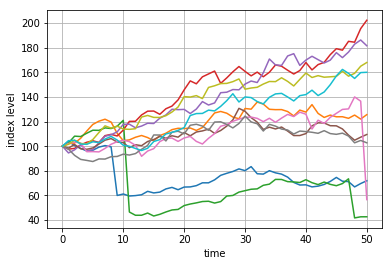

In [19]:
plt.plot(S[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)

**Variance reduction**

In [20]:
print('%15s %15s' % ('Mean', 'Std. Deviation'))
print(31 * '-')
for i in range(1, 31, 2):
    npr.seed(1000)
    sn = npr.standard_normal(i ** 2 * 10000)
    print('%15.12f %15.12f' % (sn.mean(), sn.std()))

           Mean  Std. Deviation
-------------------------------
-0.011870394558  1.008752430725
-0.002815667298  1.002729536352
-0.003847776704  1.000594044165
-0.003058113374  1.001086345326
-0.001685126538  1.001630849589
-0.001175212007  1.001347684642
-0.000803969036  1.000159081432
-0.000601970954  0.999506522127
-0.000147787693  0.999571756099
-0.000313035581  0.999646153704
-0.000178447061  0.999677277878
 0.000096501709  0.999684346792
-0.000135677013  0.999823841902
-0.000015726986  0.999906493379
-0.000039368519  1.000063091949


In [21]:
i ** 2 * 10000

8410000

In [22]:
sn = npr.standard_normal(10000 // 2)
sn = np.concatenate((sn, -sn))
np.shape(sn)

(10000,)

In [23]:
print('%15s %15s' % ('Mean', 'Std. Deviation'))
print(31 * '-')
for i in range(1, 31, 2):
    npr.seed(1000)
    sn = npr.standard_normal(i ** 2 * 10000 // 2)
    sn = np.concatenate((sn, -sn))
    print('%15.12f %15.12f' % (sn.mean(), sn.std()))

           Mean  Std. Deviation
-------------------------------
 0.000000000000  1.009653753942
-0.000000000000  1.000413716783
 0.000000000000  1.002925061201
-0.000000000000  1.000755212673
 0.000000000000  1.001636910076
-0.000000000000  1.000726758438
-0.000000000000  1.001621265149
 0.000000000000  1.001203722778
-0.000000000000  1.000556669784
 0.000000000000  1.000113464185
-0.000000000000  0.999435175324
 0.000000000000  0.999356961431
-0.000000000000  0.999641436845
-0.000000000000  0.999642768905
-0.000000000000  0.999638303451


In [24]:
sn = npr.standard_normal(10000)
print(sn.mean(), sn.std())
sn_new = (sn - sn.mean()) / sn.std()
print(sn_new.mean(),sn_new.std())


-0.001165998295162494 0.991255920204605
-2.3803181647963357e-17 0.9999999999999999


The following function utilizes the insight with regard to variance reduction techniques and generates standard normal random numbers for process simulation using either two, one, or no variance reduction technique(s):

In [25]:
def gen_sn(M, I, anti_paths=True, mo_match=True):
    ''' Function to generate random numbers for simulation.
    
    Parameters
    ==========
    M : int
        number of time intervals for discretization
    I : int
        number of paths to be simulated
    anti_paths: Boolean
        use of antithetic variates
    mo_math : Boolean
        use of moment matching
    '''
    if anti_paths is True:
        sn = npr.standard_normal((M + 1, I // 2))
        sn = np.concatenate((sn, -sn), axis=1)
    else:
        sn = npr.standard_normal((M + 1, I))
    if mo_match is True:
        sn = (sn - sn.mean()) / sn.std()
    return sn

### Valuation ###

**European Options**

The payoff of a European call option on an index at maturity is given by $h(S_T) \equiv max(S_T - K,0)$, where $S_T$ is the index level at maturity date $T$ and $K$. The price of such an option is given by the formula below:

$$\large C_0 = e^{-rT}\mathbf{E}_0^Q(h(S_T))=e^{-rT}\int_{0}^{\infty}h(s)q(s)ds$$

The following equation provides the respective Monte Carlo estimator for the European option, where $\tilde{S}_T^i$ is the $i$th simulated index level at maturity.

$$\large \tilde{C}_0 = e^{-rT}\frac{1}{I}\sum_{i=1}^{I}h(\tilde{S}_T^i)$$

Consider now the following parameterization for the geometric Brownian motion and the valuation function `gbm_mcs_stat` , taking as a parameter only the strike price. Here, only the index level at maturity is simulated:

In [26]:
S0 = 100.
r = 0.05
sigma = 0.25
T = 1.0
I = 50000
def gbm_mcs_stat(K):
    ''' Valuation of European call option in Black-Scholes-Merton
    by Monte Carlo simulation (of index level at maturity)
    
    Parameters
    ==========
    K : float
        (positive) strike price of the option
    
    Returns
    =======
    C0 : float
        estimated present value of European call option
    '''
    sn = gen_sn(1, I)
    # simulate index level at maturity
    ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T
        + sigma * np.sqrt(T) * sn[1])
    # calculate payoff at maturity
    hT = np.maximum(ST - K, 0)
    # calculate MCS estimator
    C0 = np.exp(-r * T) * 1 / I * np.sum(hT)
    return C0


gbm_mcs_stat(K=105)  # For K=105

10.044221852841922

Next, we consider the dynamic simulation approach and allow for European put options in addition to the call option. The function `gbm_mcs_dyna` implements the algorithm:

In [27]:
M = 50
def gbm_mcs_dyna(K, option='call'):
    ''' Valuation of European options in Black-Scholes-Merton
    by Monte Carlo simulation (of index level paths)
    
    Parameters
    ==========
    K : float
        (positive) strike price of the option
    option : string
        type of the option to be valued ('call', 'put')
    
    Returns
    =======
    C0 : float
        estimated present value of European call option
    '''
    dt = T / M
    # simulation of index level paths
    S = np.zeros((M + 1, I))
    S[0] = S0
    sn = gen_sn(M, I)
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt
            + sigma * np.sqrt(dt) * sn[t])
    # case-based calculation of payoff
    if option == 'call':
        hT = np.maximum(S[-1] - K, 0)
    else:
        hT = np.maximum(K - S[-1], 0)
    # calculation of MCS estimator
    C0 = np.exp(-r * T) * 1 / I * np.sum(hT)
    return C0


print(gbm_mcs_dyna(K=110., option='call'), gbm_mcs_dyna(K=110., option='put'))

7.950008525028434 12.629934942682004


The question is how well these simulation-based valuation approaches perform relative to the benchmark value from the Black-Scholes-Merton valuation formula. To find out, let us generate respective option values/estimates for a range of strike prices, using the analytical option pricing formula for European calls in Black-Scholes-Merton found in `bsm_call_value()`

/home/muveexu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


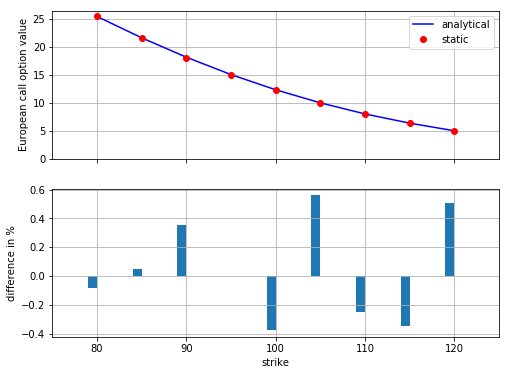

In [28]:
def bsm_call_value(S0, K, T, r, sigma):
    ''' Valuation of European call option in BSM model.
    Analytical formula.
    Parameters
    ==========
    S0 : float
        initial stock/index level
    K : float
        strike price
    T : float
        maturity date (in year fractions)
    r : float
        constant risk-free short rate
    sigma : float
        volatility factor in diffusion term
    Returns
    =======
    value : float
        present value of the European call option
    '''
    from math import log, sqrt, exp
    from scipy import stats


    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0)
        - K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    # stats.norm.cdf --> cumulative distribution function
    # for normal distribution
    return value


stat_res = []
dyna_res = []
anal_res = []
k_list = np.arange(80., 120.1, 5.)
np.random.seed(200000)
for K in k_list:
    stat_res.append(gbm_mcs_stat(K))
    dyna_res.append(gbm_mcs_dyna(K))
    anal_res.append(bsm_call_value(S0, K, T, r, sigma))
stat_res = np.array(stat_res)
dyna_res = np.array(dyna_res)
anal_res = np.array(anal_res)

# Compare the results from the static simulation approach with precise analytical values
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax1.plot(k_list, anal_res, 'b', label='analytical')
ax1.plot(k_list, stat_res, 'ro', label='static')
ax1.set_ylabel('European call option value')
ax1.grid(True)
ax1.legend(loc=0)
ax1.set_ylim(ymin=0)
wi = 1.0
ax2.bar(k_list - wi / 2, (anal_res - stat_res) / anal_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('difference in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)

All valuation differences are smaller than 1% absolutely. There are both negative and positive value differences.

A similar picture emerges for the dynamic simulation and valuation approach, whose results are reported in the following graph:

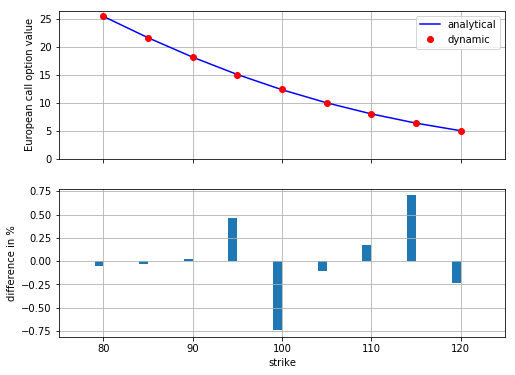

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax1.plot(k_list, anal_res, 'b', label='analytical')
ax1.plot(k_list, dyna_res, 'ro', label='dynamic')
ax1.set_ylabel('European call option value')
ax1.grid(True)
ax1.legend(loc=0)
ax1.set_ylim(ymin=0)
wi = 1.0
ax2.bar(k_list - wi / 2, (anal_res - dyna_res) / anal_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('difference in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)

**American Options**

American option prices as optimal stopping problem:

$$\large V_0= \sup_{\tau \in \{0,\Delta t,2\Delta t,...,T\}}e^{-rT}\mathbf{E}_0^Q(h_{\tau}(S_{\tau}))$$

The algorithm we describe in the following is called *Least-Squares Monte Carlo (LSM)* and is from the paper by Longstaff and Schwartz (2001). It can be shown that the value of an American (Bermudan) option at any given date $t$ is given as $V_t(s) = max(h_t(s),C_t(s))$, where

 $$\displaystyle C_t(s)=\mathbf{E}_t^Q(e^{-r\Delta T}V_{t+\Delta t}(S_{t+\Delta t})|S_t=s)$$ 

is the so-called *continuation value* of the option given an index level of $S_t = s$

Consider now that we have simulated I paths of the index level over M time intervals of equal size $\Delta t$. Define $\displaystyle Y_{t,i} \equiv e^{-r\Delta t}V_{t+\Delta t,i}$ to be the simulated continuation value for path $i$ at time $t$.

Given a set of basis functions $b_d$, $d = 1,...,D$, the continuation value is then given by the regression estimate $\hat{C}_{t,i} = \sum_{d=1}^{D}\alpha_{d,t}^{*} \cdot b_d(S_{t,i})$, where the optimal regression parameters $\alpha^*$ are the solution of the least-squares problem stated in the following equation:

$$\large \min_{\alpha_{1,t},\ldots,\alpha_{D,t}} \frac{1}{I}\sum_{i=1}^{I}\Big(Y_{t,i}-\sum_{d=1}^{D}\alpha_{d,t}\cdot b_d(S_{t,i})\Big)^2$$

The function `gbm_mcs_amer` implements the LSM algorithm for both American call and put options:

In [30]:
def gbm_mcs_amer(K, option='call'):
    ''' Valuation of American option in Black-Scholes-Merton
    by Monte Carlo simulation by LSM algorithm
    
    Parameters
    ==========
    K : float
        (positive) strike price of the option
    option : string
        type of the option to be valued ('call', 'put')
        
    Returns
    =======
    C0 : float
        estimated present value of European call option
    '''
    dt = T / M
    df = np.exp(-r * dt)
    # simulation of index levels
    S = np.zeros((M + 1, I))
    S[0] = S0
    sn = gen_sn(M, I)
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt
            + sigma * np.sqrt(dt) * sn[t])
    # case-based calculation of payoff
    if option == 'call':
        h = np.maximum(S - K, 0)
    else:
        h = np.maximum(K - S, 0)
    # LSM algorithm
    V = np.copy(h)
    for t in range(M - 1, 0, -1):
        reg = np.polyfit(S[t], V[t + 1] * df, 7)
        C = np.polyval(reg, S[t])
        V[t] = np.where(C > h[t], V[t + 1] * df, h[t])
    # MCS estimator
    C0 = df * 1 / I * np.sum(V[1])
    return C0


print(gbm_mcs_amer(110., option='call'), gbm_mcs_amer(110., option='put'))

7.778933279449316 13.614023206242445


The European value of an option represents a lower bound to the American option’s value. The difference is generally called the *early exercise premium*. In what follows, we compare European and American option values for the same range of strikes as before to estimate the option premium. This time we take puts:

> Since we do not assume any dividend payments (having an index in mind), there generally is no early exercise
premium for call options (i.e., no incentive to exercise the option early)

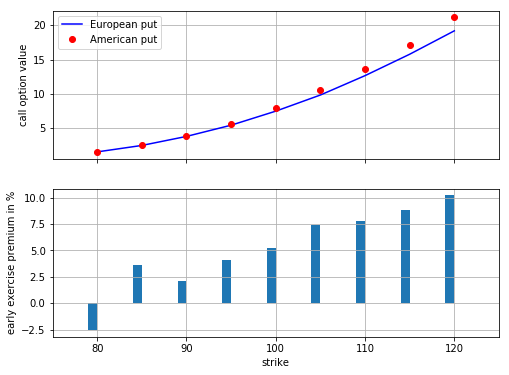

In [31]:
euro_res = []
amer_res = []
k_list = np.arange(80., 120.1, 5.)
for K in k_list:
    euro_res.append(gbm_mcs_dyna(K, 'put'))
    amer_res.append(gbm_mcs_amer(K, 'put'))
euro_res = np.array(euro_res)
amer_res = np.array(amer_res)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax1.plot(k_list, euro_res, 'b', label='European put')
ax1.plot(k_list, amer_res, 'ro', label='American put')
ax1.set_ylabel('call option value')
ax1.grid(True)
ax1.legend(loc=0)
wi = 1.0
ax2.bar(k_list - wi / 2, (amer_res - euro_res) / euro_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('early exercise premium in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)

The figure shows that for the range of strikes chosen the premium can rise to up to 10%.

### Risk Measures

**Value at risk**

Assume again that we are in a Black-Scholes-Merton setup and consider the following
parameterization and simulation of index levels at a future date $T = 30/365$

In [32]:
S0 = 100
r = 0.05
sigma = 0.25
T = 30 / 365.
I = 10000
ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T
    + sigma * np.sqrt(T) * npr.standard_normal(I))

To estimate VaR figures, we need the simulated absolute profits and losses relative to the value of the position today in a sorted manner, i.e., from the severest loss to the largest profit:

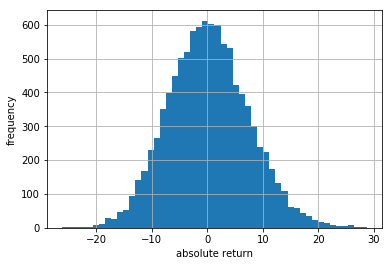

In [33]:
R_gbm = np.sort(ST - S0)
plt.hist(R_gbm, bins=50)
plt.xlabel('absolute return')
plt.ylabel('frequency')
plt.grid(True)

The 30-day VaR given a confidence level of 99.9% in this case is 20.2 currency units, while it is 8.9 at the 90% confidence level:

In [34]:
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
var = scs.scoreatpercentile(R_gbm, percs)
print("%16s %16s" % ('Confidence Level', 'Value-at-Risk'))
print(33 * "-")
for pair in zip(percs, var):
    print("%16.2f %16.3f" % (100 - pair[0], -pair[1]))




Confidence Level    Value-at-Risk
---------------------------------
           99.99           26.072
           99.90           20.175
           99.00           15.753
           97.50           13.265
           95.00           11.298
           90.00            8.942


/home/muveexu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


As a second example, recall the jump diffusion setup from Merton, which we want to simulate dynamically:

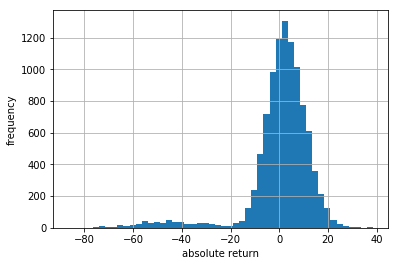

In [35]:
dt = 30. / 365 / M
rj = lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
S = np.zeros((M + 1, I))
S[0] = S0
sn1 = npr.standard_normal((M + 1, I))
sn2 = npr.standard_normal((M + 1, I))
poi = npr.poisson(lamb * dt, (M + 1, I))
for t in range(1, M + 1, 1):
    S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt
        + sigma * np.sqrt(dt) * sn1[t])
        + (np.exp(mu + delta * sn2[t]) - 1)
        * poi[t])
    S[t] = np.maximum(S[t], 0)
R_jd = np.sort(S[-1] - S0)

plt.hist(R_jd, bins=50)
plt.xlabel('absolute return')
plt.ylabel('frequency')
plt.grid(True)

we see something like a bimodal distribution for the simulated profits/losses in the figure above.

For this process and parameterization, the VaR over 30 days at the 90% level is almost identical, while it is more than three times as high at the 99.9% level as with the geometric Brownian motion.

In [36]:
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
var = scs.scoreatpercentile(R_jd, percs)
print("%16s %16s" % ('Confidence Level', 'Value-at-Risk'))
print(33 * "-")
for pair in zip(percs, var):
    print("%16.2f %16.3f" % (100 - pair[0], -pair[1]))

Confidence Level    Value-at-Risk
---------------------------------
           99.99           75.029
           99.90           71.833
           99.00           55.901
           97.50           45.697
           95.00           25.993
           90.00            8.773


This illustrates the problem of capturing the tail risk so often encountered in financial markets by the standard VaR measure. To further illustrate the point, we lastly show the VaR measures for both cases in direct comparison graphically.

/home/muveexu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(-90.27761910662304, 0.0)

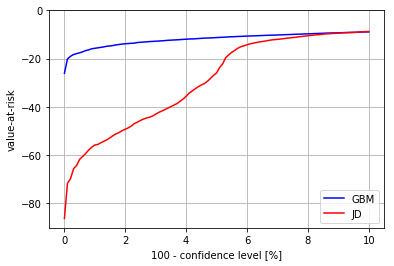

In [37]:
percs = list(np.arange(0.0, 10.1, 0.1))
gbm_var = scs.scoreatpercentile(R_gbm, percs)
jd_var = scs.scoreatpercentile(R_jd, percs)

plt.plot(percs, gbm_var, 'b', lw=1.5, label='GBM')
plt.plot(percs, jd_var, 'r', lw=1.5, label='JD')
plt.legend(loc=4)
plt.xlabel('100 - confidence level [%]')
plt.ylabel('value-at-risk')
plt.grid(True)
plt.ylim(ymax=0.0)

**Credit Value Adjustments**

CVaR is a measure for the risk resulting from the possibility that a counterparty might not be able to honor its obligations. In such a case there are two main assumptions to be made: *probability of default* and the (average) *loss level*.

consider again the benchmark setup of Black-Scholes-Merton with the following parameterization. In the simplest case, one considers a fixed (average) loss level $L$ and a fixed probability $p$ for default (per year) of a counterparty:

In [38]:
S0 = 100.
r = 0.05
sigma = 0.2
T = 1.
I = 100000
ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T
    + sigma * np.sqrt(T) * npr.standard_normal(I))
L = 0.5
p = 0.01

D = npr.poisson(p * T, I)
D = np.where(D > 1, 1, D)



Without default, the risk-neutral value of the future index level should be equal to the current value of the asset today (up to differences resulting from numerical errors):

In [39]:
np.exp(-r * T) * 1 / I * np.sum(ST)

99.98182521684292

The CVaR under our assumptions is calculated as follows:

In [40]:
CVaR = np.exp(-r * T) * 1 / I * np.sum(L * D * ST)
print(CVaR)

0.5152011134161355


The present value of the asset, adjusted for the credit risk, is given as follows:

In [41]:
S0_CVA = np.exp(-r * T) * 1 / I * np.sum((1 - L * D) * ST)
print(S0_CVA)

99.46662410342678


This should be (roughly) the same as subtracting the CVaR value from the current asset value:

In [42]:
S0_adj = S0 - CVaR
print(S0_adj)

99.48479888658386


In this particular simulation example, we observe roughly 1,000 losses due to credit risk, which is to be expected given the assumed default probability of 1% and 100,000 simulated paths:

In [43]:
np.count_nonzero(L * D * ST)

1031

The following figure shows the complete frequency distribution of the losses due to a default. Of course, in the large majority of cases (i.e., in about 99,000 of the 100,000 cases) there is no loss to observe:

(0.0, 175)

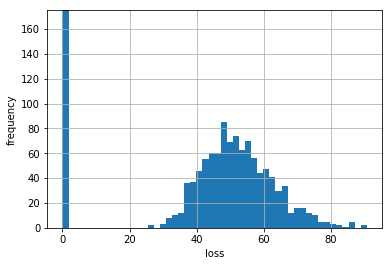

In [44]:
plt.hist(L * D * ST, bins=50)
plt.xlabel('loss')
plt.ylabel('frequency')
plt.grid(True)
plt.ylim(ymax=175)

Consider now the case of a European call option. Its value is about 10.4 currency units at a strike of 100:

In [45]:
K = 100.
hT = np.maximum(ST - K, 0)
C0 = np.exp(-r * T) * 1 / I * np.sum(hT)
C0

10.427336109660052

The CVaR is about 5 cents given the same assumptions with regard to probability of default and loss level:

In [46]:
CVaR = np.exp(-r * T) * 1 / I * np.sum(L * D * hT)
CVaR

0.05382257845220809

Accordingly, the adjusted option value is roughly 5 cents lower:

In [47]:
C0_CVA = np.exp(-r * T) * 1 / I * np.sum((1 - L * D) * hT)
C0_CVA

10.373513531207843

Compared to the case of a regular asset, the option case has somewhat different characteristics. We only see a little more than 500 losses due to a default, although we again have about 1,000 defaults. This results from the fact that the payoff of the option at maturity has a high probability of being zero:

In [48]:
# number of losses
np.count_nonzero(L * D * hT)


582

In [49]:
# number of defaults
np.count_nonzero(D)

1031

In [50]:
# zero payoff
I - np.count_nonzero(hT)

43995

The following figure shows that the CVaR for the option has a completely different frequency distribution compared to the regular asset case:

(0.0, 350)

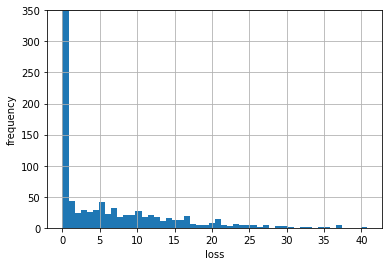

In [51]:
plt.hist(L * D * hT, bins=50)
plt.xlabel('loss')
plt.ylabel('frequency')
plt.grid(True)
plt.ylim(ymax=350)